#Environment Setup

In [1]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00


Importing required libraries

In [2]:
from capsule_network import *
from dataloader import image_dataloader

from PIL import Image

import torch
from torch.optim import Adam

from datasets import load_dataset

from scipy.stats import pearsonr, spearmanr, kendalltau
from thop import profile

Using device: cuda


Device (CPU/GPU) available to use.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## DataLoaders

In [4]:
class TinyImageNetDataset(Dataset):
    def __init__(self, split='train'):
        '''
        split: Valid values are ['train', 'valid']
        '''
        self.transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize(64),      # Size of a tiny-imagenet image: (64, 64)
                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

        self.dataset = load_dataset('Maysee/tiny-imagenet', split=split)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image = self.dataset[index]['image']
        image = image.convert("RGB")
        transformed_img = self.transform(image)
        return transformed_img, self.dataset[index]['label']

In [5]:
def image_dataloader(dataset='mnist', batch_size=100):
    if dataset == 'mnist':
        transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))])

        trainset = datasets.MNIST('/data/mnist', train=True, download=True, transform=transform)
        testset = datasets.MNIST('/data/mnist', train=False, download=True, transform=transform)

    elif dataset == 'cifar10':
        transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(32),      # Size of a cifar10 image: (32, 32)
                transforms.Normalize((0.485, 0.456, 0.406) , (0.229, 0.224, 0.225))])

        trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
        testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    elif dataset == 'tinyimagenet':
        trainset = TinyImageNetDataset(split='train')
        testset = TinyImageNetDataset(split='valid')

    else:
        raise ValueError("Argument 'dataset' must be one of the values in ['cifar10, 'tinyimagenet'].")

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

## Capsule Network

### Convolutional Layer

In [6]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels=256, kernel_size=9, stride=1, *args, **kwargs):
        super(ConvLayer, self).__init__(*args, **kwargs)

        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)

    def forward(self, x):
        return F.relu(self.conv_layer(x))

In [7]:
def get_conv_out_dim(img_h, img_w, kernel_size, stride, padding=0):
    out_h = (int((img_h + (2*padding) - kernel_size) / stride)) + 1
    out_w = (int((img_w + (2*padding) - kernel_size) / stride)) + 1
    return out_h, out_w

### Primary Capsule Layer

In [8]:
def squash(tensor, dim=-1):
    sqr_norm = torch.sum(tensor**2, dim=dim, keepdim=True)
    norm = torch.sqrt(sqr_norm)
    return (sqr_norm * tensor) / ((1. + sqr_norm) * norm)

In [9]:
class PrimaryCapsLayer(nn.Module):
    def __init__(self, in_channels=256, out_channels=32, out_caps_dim=8, kernel_size=9, stride=2, padding='valid', *args, **kwargs):
        super(PrimaryCapsLayer, self).__init__(*args, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.out_caps_dim = out_caps_dim
        self.kernel_size = kernel_size
        self.stride = stride
        self.n_prim_caps = None

        self.primary_caps = nn.ModuleList(
            [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
             for _ in range(out_caps_dim)])

    def forward(self, x):
        if self.n_prim_caps is None:
            conv_out_dim1, conv_out_dim2 = get_conv_out_dim(x.size(-2),             # Calculate convolutional output dimension for zero padding
                                                            x.size(-1),
                                                            self.kernel_size,
                                                            self.stride)
            self.n_prim_caps = conv_out_dim1 * conv_out_dim2 * self.out_channels    # Get number of capsules in the output

        batch_size = x.size(0)
        u_list = [capsule(x) for capsule in self.primary_caps]  # Output capsule shape: (batch_size, out_channels, conv_out_dim1, conv_out_dim2)
        u = torch.stack(u_list, dim=-1)                         # Stacking capsule output to get shape: (batch_size, out_channels, conv_out_dim1, conv_out_dim2, out_caps_dim)
        u = u.view(batch_size, self.n_prim_caps, -1)            # Reshape the tensor to (batch_size, prim_caps_out_dim, out_caps_dim)
        return squash(u)                                        # Squash returns the tensor shape: (batch_size, prim_caps_out_dim, out_caps_dim)

### Class Capsule Layer

In [10]:
class ClassCapsLayer(nn.Module):
    def __init__(self, n_class, n_prim_caps, in_caps_dim=8, out_caps_dim=16, *args, **kwargs):
        super(ClassCapsLayer, self).__init__(*args, **kwargs)

        self.n_class = n_class
        self.n_prim_caps = n_prim_caps
        self.in_caps_dim = in_caps_dim
        self.out_caps_dim = out_caps_dim

        self.weights = nn.Parameter(torch.randn(n_prim_caps, n_class, out_caps_dim, in_caps_dim))

    def forward(self, u):
        batch_size = u.size(0)
        W = torch.stack([self.weights] * batch_size, dim=0)         # W Shape: (batch_size, n_prim_caps, n_class, out_caps_dim, in_caps_dim)
        # print("W shape: ", W.size())
        u = torch.stack([u] * self.n_class, dim=2).unsqueeze(-1)    # u Shape: (batch_size, n_prim_caps, n_class, in_caps_dim, 1)
        # print("u shape: ", u.size())
        u_hat = torch.matmul(W, u)                                  # u_hat Shape: (batch_size, n_prim_caps, n_class, out_caps_dim, 1)
        return u_hat

### Routing Aggreement

In [11]:
class RoutingByAggreement(nn.Module):
    def __init__(self, n_in_caps, n_out_caps,  n_iterations=3, *args, **kwargs):
        super(RoutingByAggreement, self).__init__(*args, **kwargs)

        self.n_in_caps = n_in_caps
        self.n_out_caps = n_out_caps
        self.n_iterations = n_iterations

    def forward(self, u_hat):
        # print("u_hat: ", u_hat.size())
        batch_size = u_hat.size(0)      # u_hat Shape: (batch_size, n_in_caps, n_out_caps, output_capsule_dim, 1)

        bij = Variable(torch.zeros(batch_size, self.n_in_caps, self.n_out_caps, 1, 1, dtype=torch.float, device=device)) # bij Shape: (batch_size, n_in_caps, n_out_caps, 1, 1)
        # print("bij shape: ", bij.shape)

        for r in range(self.n_iterations):
            cij = F.softmax(bij, dim=1)                             # cij Shape: (batch_size, n_in_caps, n_out_caps, 1, 1)
            # print("cij shape: ", cij.shape)
            sj = (cij * u_hat).sum(dim=1, keepdim=True)             # sj Shape: (batch_size, 1, n_out_caps, output_capsule_dim, 1)
            # print("sj shape: ", sj.shape)
            vj = squash(sj, dim=-2)                                 # vj Shape: (batch_size, 1, n_out_caps, output_capsule_dim, 1)
            vj_in_caps = torch.cat([vj] * self.n_in_caps, dim=1)    # vj Shape: (batch_size, n_in_caps, n_out_caps, output_capsule_dim, 1)
            u_hat_T = u_hat.transpose(-2, -1)
            # print("vj_in_caps shape: ", vj_in_caps.shape)
            # print("u_hat_T shape: ", u_hat_T.shape)

            if r < self.n_iterations - 1:
                aij = torch.matmul(u_hat_T, vj_in_caps)             # aij Shape: (batch_size, n_in_caps, n_out_caps, 1, 1)
                # print("aij shape: ", aij.shape)
                bij = bij + aij

        # print("vj squeezed shape: ", vj.squeeze(1).shape)
        return vj.squeeze(1)     # vj Shape Squeezed: (batch_size, n_out_caps, output_capsule_dim, 1)

### Decoder Network

In [12]:
class CapsDecoder(nn.Module):
    def __init__(self, n_class, in_img_c, in_img_h, in_img_w, out_capsule_dim=16, *args, **kwargs):
        super(CapsDecoder, self).__init__(*args, **kwargs)

        self.n_class = n_class
        self.in_img_c = in_img_c
        self.in_img_h = in_img_h
        self.in_img_w = in_img_w

        fcl_input_dim = out_capsule_dim * n_class
        fcl_ouput_dim = in_img_c * in_img_h * in_img_w

        self.fully_conn_layers = nn.Sequential(
            nn.Linear(fcl_input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, fcl_ouput_dim),
            nn.Sigmoid())

    def forward(self, v):
        # print("v shape: ", v.shape)
        # print("v: ", v[0][0])
        caps_out_class = torch.sqrt((v ** 2).sum(dim=2))   # v shape: (batch_size, n_class, out_capsule_dim, 1)
        caps_out_class = caps_out_class.squeeze()           # caps_out_class shape: (batch_size, n_class)
        # print("caps_out_class shape:", caps_out_class.shape)
        # print("caps_out_class: ", caps_out_class[0])
        caps_out_class = F.softmax(caps_out_class, dim=1)      # caps_out_class Shape: (batch_size, n_class)
        # print("caps_out_class shape after softmax:", caps_out_class.shape)
        # print("caps_out_class: ", caps_out_class[0])
        max_class_indices = caps_out_class.argmax(dim=1)
        # print("max_class_indices: ",max_class_indices)
        masked_matrix = Variable(torch.eye(self.n_class, device=device))
        masked_matrix = masked_matrix.index_select(dim=0, index=max_class_indices.squeeze())       # masked_matrix Shape: (batch_size, n_class)

        v = v * masked_matrix[:, :, None, None]           # v Shape: (batch_size, n_class, out_capsule_dim, 1)
        flattened_v = v.view(v.size(0), -1)             # flattened_v Shape: (batch_size, n_class * out_capsule_dim * 1)

        reconstructed_img = self.fully_conn_layers(flattened_v)    # reconstructed_img Shape: (batch_size, fcl_ouput_dim)
        reconstructed_img = reconstructed_img.view(-1, self.in_img_c, self.in_img_h, self.in_img_w)   # reconstructed_img Shape: (batch_size, in_img_ch, in_img_h, in_img_w)

        return reconstructed_img

### Capsule Network Loss

In [13]:
class CapsNetLoss(nn.Module):
    def __init__(self, lmbda=0.5, m_positive=0.9, m_negative=0.1, recon_loss_scale_factor=0.0005, *args, **kwargs):
        super(CapsNetLoss, self).__init__(*args, **kwargs)

        self.lmbda = lmbda
        self.m_positive = m_positive
        self.m_negative = m_negative
        self.recon_loss_scale_factor = recon_loss_scale_factor
        self.mse_loss = nn.MSELoss()

    def forward(self, v, labels, images, reconstructed_images):
        return self.margin_loss(v, labels) + self.reconstruction_loss(images, reconstructed_images)

    def margin_loss(self, v, labels):
        vk = torch.sqrt((v**2).sum(dim=-2, keepdim=True))
        # print("vk shape:", vk.shape)

        batch_size = v.size(0)

        present_error = F.relu(self.m_positive - vk).view(batch_size, -1)**2
        absent_error = F.relu(vk - self.m_negative).view(batch_size, -1)**2

        # print("present_error shape:", present_error.shape)
        # print("absent_error shape:", absent_error.shape)

        Tk = F.one_hot(labels)
        # print("Tk shape:", Tk.shape)

        loss = (Tk * present_error) + (self.lmbda * (1 - Tk) * absent_error)
        loss = loss.sum(dim=1).mean()

        return loss

    def reconstruction_loss(self, images, reconstructed_images):
        return self.mse_loss(reconstructed_images, images) * self.recon_loss_scale_factor


In [14]:
class BaseCapsuleNetwork(nn.Module):
    def __init__(self, in_img_c, in_img_h, in_img_w, n_class, *args, **kwargs):
        super(BaseCapsuleNetwork, self).__init__(*args, **kwargs)

        self.conv_layer = ConvLayer(in_channels=in_img_c, kernel_size=9, stride=1)

        conv_layer_out_dim1, conv_layer_out_dim2 = get_conv_out_dim(in_img_h, in_img_w, kernel_size=9, stride = 1)

        self.primary_caps = PrimaryCapsLayer(out_channels=32, kernel_size=9, stride=2)

        prim_caps_out_dim1, prim_caps_out_dim2 = get_conv_out_dim(conv_layer_out_dim1, conv_layer_out_dim2, kernel_size=9, stride = 2)
        n_prim_caps = prim_caps_out_dim1 * prim_caps_out_dim2 * 32

        self.class_caps = ClassCapsLayer(n_class=n_class, n_prim_caps=n_prim_caps)
        self.routing_aggreement = RoutingByAggreement(n_in_caps=n_prim_caps, n_out_caps=n_class)
        self.caps_decoder = CapsDecoder(n_class, in_img_c, in_img_h, in_img_w)

    def forward(self, images):
        conv_output = self.conv_layer(images)
        primary_caps_output = self.primary_caps(conv_output)
        class_caps_output = self.class_caps(primary_caps_output)
        pred = self.routing_aggreement(class_caps_output)
        reconstructed_img = self.caps_decoder(pred)
        return reconstructed_img, pred


In [4]:
base_capsnet_cifar10 = BaseCapsuleNetwork(3, 32, 32, n_class=10)
base_capsnet_cifar10 = base_capsnet_cifar10.to(device)
optimizer = Adam(base_capsnet_cifar10.parameters())

train_loader, test_loader = image_dataloader(dataset='cifar10')

criterion = CapsNetLoss()
n_epochs = 30

100%|██████████| 170498071/170498071 [00:01<00:00, 93353411.74it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [16]:
# base_capsnet_mnist = BaseCapsuleNetwork(1, 28, 28, n_class=10)
# base_capsnet_mnist = base_capsnet_mnist.to(device)
# optimizer = Adam(base_capsnet_mnist.parameters())

# train_loader, test_loader = image_dataloader(dataset='mnist')

In [5]:
losses = []

for epoch in range(1, n_epochs+1):
    base_capsnet_cifar10.train()
    train_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        batch_size = len(images)
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        reconstructed_images, preds = base_capsnet_cifar10(images)

        loss = criterion(preds, labels, images, reconstructed_images)
        loss.backward()
        optimizer.step()

        train_loss += loss

        losses.append(loss)

    print("Epoch {} - Average Training Loss: {}".format(epoch, train_loss / len(train_loader)))

Epoch 1 - Average Training Loss: 0.3779374361038208
Epoch 2 - Average Training Loss: 0.3014434576034546
Epoch 3 - Average Training Loss: 0.26901787519454956
Epoch 4 - Average Training Loss: 0.24630065262317657
Epoch 5 - Average Training Loss: 0.227930948138237
Epoch 6 - Average Training Loss: 0.21207235753536224
Epoch 7 - Average Training Loss: 0.19771838188171387
Epoch 8 - Average Training Loss: 0.18229927122592926
Epoch 9 - Average Training Loss: 0.16912971436977386
Epoch 10 - Average Training Loss: 0.1543203592300415
Epoch 11 - Average Training Loss: 0.13978959619998932
Epoch 12 - Average Training Loss: 0.12578661739826202
Epoch 13 - Average Training Loss: 0.11042008548974991
Epoch 14 - Average Training Loss: 0.0959852859377861


KeyboardInterrupt: ignored

In [11]:
base_capsnet_cifar10_flops, base_capsnet_cifar10_params = profile(base_capsnet_cifar10, inputs=(images,))

print("Base CapsNet CIFAR10 Flops = {:.2f}".format(base_capsnet_cifar10_flops))
print("Base CapsNet CIFAR10 Params = {:.2f}".format( base_capsnet_cifar10_params))

NameError: ignored

In [20]:
base_capsnet_cifar10.eval()
test_loss = 0

for batch_id, (data, target) in enumerate(test_loader):
    batch_size = len(images)
    images = images.to(device)
    labels = labels.to(device)

    reconstructed_images, preds, masked_preds = base_capsnet_cifar10(images)
    loss = criterion(preds, labels, images, reconstructed_images)

    test_loss += loss

    if batch_id % 100 == 0:
        print("Test Accuracy:", sum(np.argmax(masked_preds.data.cpu().numpy(), 1) ==
                                np.argmax(labels.data.cpu().numpy())) / float(batch_size))

print("Test Loss: ", test_loss / len(test_loader))

ValueError: ignored

In [6]:
import matplotlib
import matplotlib.pyplot as plt

def plot_images_separately(images):
    fig = plt.figure()
    for j in range(1, 7):
        ax = fig.add_subplot(1, 6, j)
        image = images[j-1]
        ax.imshow(image.T)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

<ipython-input-6-15cb3a95207b>:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  ax.imshow(image.T)


NameError: ignored

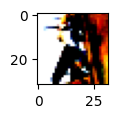

In [7]:
plot_images_separately(images[:6, :].cpu())

In [ ]:
recon_image = reconstructed_images[4]
recon_image = recon_image.cpu().detach().numpy()

plt.imshow(recon_image.T)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(100)))

**Sangita Try


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import datasets, transforms

USE_CUDA = True

In [ ]:
class Mnist:
    def __init__(self, batch_size):
        dataset_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

        train_dataset = datasets.MNIST('../data', train=True, download=True, transform=dataset_transform)
        test_dataset = datasets.MNIST('../data', train=False, download=True, transform=dataset_transform)

        self.train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9):
        super(ConvLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=kernel_size,
                               stride=1
                             )

    def forward(self, x):
        return F.relu(self.conv(x))

In [ ]:
class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=9):
        super(PrimaryCaps, self).__init__()

        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0)
                          for _ in range(num_capsules)])

    def forward(self, x):
        u = [capsule(x) for capsule in self.capsules]
        u = torch.stack(u, dim=1)
        u = u.view(x.size(0), 32 * 6 * 6, -1)
        return self.squash(u)

    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor

In [ ]:
class DigitCaps(nn.Module):
    def __init__(self, num_capsules=10, num_routes=32 * 6 * 6, in_channels=8, out_channels=16):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)

        W = torch.cat([self.W] * batch_size, dim=0)
        u_hat = torch.matmul(W, x)

        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        if USE_CUDA:
            b_ij = b_ij.cuda()

        num_iterations = 3
        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = self.squash(s_j)

            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)

    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.reconstraction_layers = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )

    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes)

        _, max_length_indices = classes.max(dim=1)
        masked = Variable(torch.sparse.torch.eye(10))
        if USE_CUDA:
            masked = masked.cuda()
        masked = masked.index_select(dim=0, index=max_length_indices.squeeze(1).data)

        reconstructions = self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), -1))
        reconstructions = reconstructions.view(-1, 1, 28, 28)

        return reconstructions, masked

In [ ]:
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()

        self.mse_loss = nn.MSELoss()

    def forward(self, data):
        output = self.digit_capsules(self.primary_capsules(self.conv_layer(data)))
        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked

    def loss(self, data, x, target, reconstructions):
        return self.margin_loss(x, target) + self.reconstruction_loss(data, reconstructions)

    def margin_loss(self, x, labels, size_average=True):
        batch_size = x.size(0)

        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)

        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()

        return loss

    def reconstruction_loss(self, data, reconstructions):
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss * 0.0005

In [ ]:
capsule_net = CapsNet()
if USE_CUDA:
    capsule_net = capsule_net.cuda()
optimizer = Adam(capsule_net.parameters())

RuntimeError: ignored

In [ ]:
batch_size = 100
mnist = Mnist(batch_size)

n_epochs = 30


for epoch in range(n_epochs):
    capsule_net.train()
    train_loss = 0
    for batch_id, (data, target) in enumerate(mnist.train_loader):

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]

        if batch_id % 100 == 0:
            print "train accuracy:", sum(np.argmax(masked.data.cpu().numpy(), 1) ==
                                   np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size)

    print train_loss / len(mnist.train_loader)

    capsule_net.eval()
    test_loss = 0
    for batch_id, (data, target) in enumerate(mnist.test_loader):

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)

        test_loss += loss.data[0]

        if batch_id % 100 == 0:
            print "test accuracy:", sum(np.argmax(masked.data.cpu().numpy(), 1) ==
                                   np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size)

    print test_loss / len(mnist.test_loader)


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

def plot_images_separately(images):
    "Plot the six MNIST images separately."
    fig = plt.figure()
    for j in xrange(1, 7):
        ax = fig.add_subplot(1, 6, j)
        ax.matshow(images[j-1], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [ ]:
plot_images_separately(data[:6,0].data.cpu().numpy())